In [1]:
#!pip install geopandas
#!pip install descartes
# https://python-visualization.github.io/folium/quickstart.html#Getting-Started
#!pip install folium
#!pip install mapboxgl

#https://hvplot.holoviz.org/user_guide/Geographic_Data.html
#!pip install hvplot
#!pip install geoviews
%matplotlib inline

In [3]:
import pandas as pd
import geopandas
import sqlite3
from shapely import wkt
import folium
from mapboxgl.viz import *
from mapboxgl.utils import *


# Must be a public token, starting with `pk`
token = 'pk.eyJ1IjoiY2Ftd2F0c29uIiwiYSI6ImNqZXNwd285bDB5cnAyd212Y3pucjN5YnQifQ.Xj3cN1bUdRebhyJJy2yunQ'

In [4]:
conn = sqlite3.connect('cap_data.db')
#query = "select * from cap_alerts"
#query = "select cap_alerts.refID, cap_alerts.identifier, cap_alerts.sender, cap_alerts.sent, cap_alerts.status, cap_alerts.msgType, cap_alerts.rev_refid, cap_info.infoID, cap_info.expires,cap_info.event,cap_info.category,cap_info.certainty,cap_info.severity,cap_info.headline,cap_info.description,cap_info.instruction,cap_poly.polygon from cap_alerts, cap_info, cap_area, cap_poly where cap_alerts.refID = cap_info.refID and cap_info.refid = cap_area.refID and cap_info.infoid = cap_area.infoID and cap_area.areaDesc = cap_poly.areaDesc and datetime(cap_info.expires) >= datetime('now') ORDER BY cap_info.expires ASC"
query = """select cap_alerts.refID,
	cap_alerts.identifier, 
	cap_alerts.sender, 
	cap_alerts.sent, 
	cap_alerts.status,
	cap_alerts.msgType,
	cap_info.infoID,    
	cap_info.expires,
	cap_info.event,
	cap_info.category,
	cap_info.responseType,
	cap_info.certainty,
	cap_info.severity,
	cap_info.urgency,
	cap_info.headline,
	cap_info.description,
	cap_info.instruction,
	cap_poly.polygon,
	cap_alerts.rev_refID
	from cap_alerts, cap_info, cap_area, cap_poly 
	where cap_alerts.refID = cap_info.refID 
	and cap_info.refid = cap_area.refID 
	and cap_info.infoid = cap_area.infoID 
	and cap_area.areaDesc = cap_poly.areaDesc
	and datetime(cap_info.expires) >= datetime('now')
	and rev_refID is NULL
	ORDER BY cap_alerts.sent DESC
"""
df = pd.read_sql_query(query,conn)


In [5]:
#df.head()

,refID,identifier,sender,sent,status,msgType,infoID,expires,event,category,responseType,certainty,severity,urgency,headline,description,instruction,polygon,rev_refID
0,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.0645848...",urn:oid:2.49.0.1.124.0645848341.2020,cap-pac@canada.ca,2020-07-08T19:47:14-00:00,Actual,Alert,0,2020-07-08T22:46:14-00:00,thunderstorm,Met,Monitor,Likely,Moderate,Immediate,severe thunderstorm warning in effect,\n###\n\nHeavy downpours are likely to cause f...,"\nTake cover immediately, if threatening weath...","POLYGON ((-81.753 43.3073, -81.755 43.2931, -8...",None
1,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.4049839...",urn:oid:2.49.0.1.124.4049839929.2020,cap-pac@canada.ca,2020-07-08T19:40:28-00:00,Actual,Update,0,2020-07-08T20:40:28-00:00,thunderstorm,Met,AllClear,Observed,Minor,Past,severe thunderstorm warning ended,\nSevere thunderstorms have weakened or moved ...,None,"POLYGON ((-79.1495 43.8216, -79.1091 43.7985, ...",None
2,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.4049839...",urn:oid:2.49.0.1.124.4049839929.2020,cap-pac@canada.ca,2020-07-08T19:40:28-00:00,Actual,Update,0,2020-07-08T20:40:28-00:00,thunderstorm,Met,AllClear,Observed,Minor,Past,severe thunderstorm warning ended,\nSevere thunderstorms have weakened or moved ...,None,"POLYGON ((-79.5327 43.5834, -79.5036 43.5329, ...",None
3,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.3692988...",urn:oid:2.49.0.1.124.3692988667.2020,cap-pac@canada.ca,2020-07-08T19:40:22-00:00,Actual,Update,0,2020-07-09T02:09:22-00:00,squall,Met,Monitor,Possible,Severe,Expected,squall watch in effect,\nConditions are favourable for the developmen...,\nMariners are advised to prepare for potentia...,"POLYGON ((-71.5143 48.6026, -71.6965 48.3512, ...",None
4,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.3692988...",urn:oid:2.49.0.1.124.3692988667.2020,cap-pac@canada.ca,2020-07-08T19:40:22-00:00,Actual,Update,0,2020-07-09T02:09:22-00:00,squall,Met,Monitor,Possible,Severe,Expected,squall watch in effect,\nConditions are favourable for the developmen...,\nMariners are advised to prepare for potentia...,"POLYGON ((-73.2342 45.1648, -73.2202 45.1095, ...",None


In [6]:
# Convert WKT data in polygon column to shapely format for gdf
df['polygon'] = df['polygon'].apply(wkt.loads)
#df.head()

In [7]:
# Create GeoDataFrame
gdf = geopandas.GeoDataFrame(df, geometry='polygon')

In [8]:
# Dissolve data based on ID and info_count 
gdf = gdf.dissolve(by=['identifier', 'infoID'], aggfunc='first')

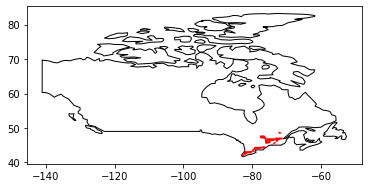

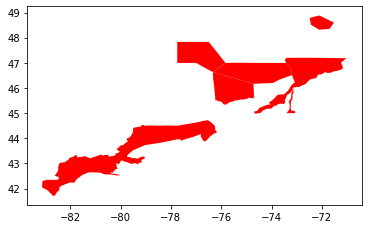

In [9]:
import matplotlib.pyplot as plt

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'Canada'].plot(
    color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')
gdf.plot(color='red')
plt.show()

In [10]:
gdf.count()

polygon         9
refID           9
sender          9
sent            9
status          9
msgType         9
expires         9
event           9
category        9
responseType    9
certainty       9
severity        9
urgency         9
headline        9
description     9
instruction     3
rev_refID       0
dtype: int64

In [11]:
# Write out to GeoJson file.
gdf.to_file("cdn_alerts.geojson", driver='GeoJSON')

In [13]:
#gdf.to_file("ShapeFiles/cdn_alerts.shp", driver='ESRI Shapefile')

In [14]:
#import fiona
#fiona.supported_drivers

In [18]:
match_color_stops = [['AllClear', 'rgb(46,204,113)'],
                     ['Monitor', 'rgb(231,76,60)']]
# https://raw.githubusercontent.com/camwatson/SpatialDataSets/master/Canada_Alerts_English.geojson"
viz = ChoroplethViz("./cdn_alerts.geojson", 
                    access_token=token,
                    color_property='responseType', 
                    color_stops=match_color_stops, 
                    color_function_type='match', 
                    color_default='rgba(52,73,94,0.5)', 
                    opacity=0.8, 
                    center=(-96, 55), 
                    zoom=3, 
                    below_layer='waterway-label')
viz.show()



In [16]:
m = folium.Map(
    location=[55, -130],
    zoom_start=2  # Limited levels of zoom for free Mapbox tiles.
)

folium.GeoJson(
    gdf.to_json(),
    name='geojson',
).add_to(m)


In [17]:
m